# Simulating Population Groups Distributed Randomly in Space

For conducting single-value inference, the `segregation` package offer several techniques for generating random population distributions that respect the characteristics of an input dataset. This notebook walks through the assumptions and outputs of each approach

## TL:DR:

- evenness includes group-level variation
- systematic includes unit-level variation
- individual permutation includes neither

In [1]:
%load_ext watermark
%watermark -a 'eli knaap' -v -d -u -p segregation,geopandas,geosnap

Author: eli knaap

Last updated: 2021-07-23

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.23.1

segregation: 2.0.0
geopandas  : 0.9.0
geosnap    : 0.6.0



In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from segregation.singlegroup import Gini
from segregation.inference import SingleValueTest

In [3]:
from geosnap import Community
dc=Community.from_census(msa_fips='47900', years=[2010]).gdf

In [4]:
dc = dc.to_crs(dc.estimate_utm_crs())

In [5]:
dc.n_nonhisp_black_persons.sum()

1426445.0

In [6]:
dc.n_total_pop.sum()

5671300.0

In [7]:
dc.n_nonhisp_black_persons.sum() / dc.n_total_pop.sum()

0.2515199337012678

In [8]:
gini = Gini(dc, group_pop_var='n_nonhisp_black_persons', total_pop_var='n_total_pop')

In [9]:
from segregation.inference import simulate_evenness, simulate_person_permutation, simulate_systematic_randomization, simulate_null

## Evenness

Evenness takes draws from the population of each unit, with the probability of choosing group X equal to its regional share (locations drawing from distributions of population groups)

In [10]:
# the regional share of nonhispanic black people in the DC region is ~25%
dc.n_nonhisp_black_persons.sum() / dc.n_total_pop.sum()

0.2515199337012678

In [11]:
dc[['n_total_pop']].reset_index(drop=True).head()

,n_total_pop
0,6426.0
1,2076.0
2,3262.0
3,4472.0
4,5164.0


Taking 6426 draws for the tract 0 (a draw for each person), on each draw there's a 25% chance that the chosen person is black 

In [12]:
evenness = simulate_evenness(dc, group='n_nonhisp_black_persons', total='n_total_pop')

In [13]:
evenness

,n_nonhisp_black_persons,n_total_pop,geometry
0,1651,6426,"POLYGON ((325727.127 4312553.019, 325904.657 4..."
1,531,2076,"POLYGON ((329869.083 4307078.613, 329855.540 4..."
2,803,3262,"POLYGON ((323597.460 4315959.397, 323899.586 4..."
3,1094,4472,"POLYGON ((320037.099 4312414.480, 320698.581 4..."
4,1278,5164,"POLYGON ((319872.327 4312900.831, 319977.124 4..."
...,...,...,...
1355,981,4003,"POLYGON ((336209.349 4328432.396, 336301.465 4..."
1356,330,1458,"POLYGON ((317434.028 4320902.735, 317696.001 4..."
1357,1416,5559,"POLYGON ((323897.744 4330418.354, 324124.997 4..."
1358,1013,3958,"POLYGON ((306054.298 4367605.376, 306101.675 4..."


<AxesSubplot:>

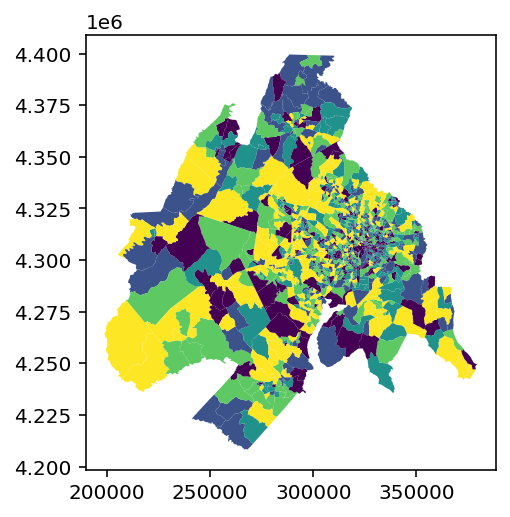

In [14]:
evenness.plot('n_nonhisp_black_persons', scheme='quantiles')

In [15]:
evenness.n_nonhisp_black_persons.sum()

1427757

In [16]:
evenness.n_nonhisp_black_persons.sum() == dc.n_nonhisp_black_persons.sum()

False

In [17]:
evenness.n_nonhisp_black_persons.sum() / evenness.n_total_pop.sum()

0.2517512739583517

In [18]:
dc.n_nonhisp_black_persons.sum() / dc.n_total_pop.sum()

0.2515199337012678

In [19]:
evenness.n_nonhisp_black_persons.sum() / evenness.n_total_pop.sum() == dc.n_nonhisp_black_persons.sum() / dc.n_total_pop.sum()

False

In [20]:
evenness.n_total_pop.sum() == dc.n_total_pop.sum()

True

In [21]:
evenness.n_total_pop.values == dc.n_total_pop.values

array([ True,  True,  True, ...,  True,  True,  True])

We haven't changed total population in each unit or the region, but we have changed the number of `group X` in the region marginally

## Systematic Randomization

The systematic approach takes draws from the regional population of each group, with the probability of choosing geographic unit X equal to the share of the region's population that currently lives there (people drawing from a distribution of locations)

In [22]:
dc.n_nonhisp_black_persons.sum()

1426445.0

In [23]:
1426445.0

1426445.0

In [24]:
(dc.n_total_pop / dc.n_total_pop.sum()).reset_index(drop=True).head()

0    0.001133
1    0.000366
2    0.000575
3    0.000789
4    0.000911
Name: n_total_pop, dtype: float64

Out of 1426445 nonhispanic black people in the DC region there's a 0.1133% chance that they will live in tract 0

In [25]:
systematic = simulate_systematic_randomization(dc, group='n_nonhisp_black_persons', total='n_total_pop')

In [26]:
systematic

,index,geometry,n_nonhisp_black_persons,other_group_pop,n_total_pop
0,8049,"POLYGON ((325727.127 4312553.019, 325904.657 4...",1625,4825,6450
1,8050,"POLYGON ((329869.083 4307078.613, 329855.540 4...",525,1550,2075
2,8051,"POLYGON ((323597.460 4315959.397, 323899.586 4...",772,2431,3203
3,8052,"POLYGON ((320037.099 4312414.480, 320698.581 4...",1055,3328,4383
4,8053,"POLYGON ((319872.327 4312900.831, 319977.124 4...",1346,3876,5222
...,...,...,...,...,...
1355,54881,"POLYGON ((336209.349 4328432.396, 336301.465 4...",1061,2956,4017
1356,54888,"POLYGON ((317434.028 4320902.735, 317696.001 4...",348,1102,1450
1357,54893,"POLYGON ((323897.744 4330418.354, 324124.997 4...",1367,4152,5519
1358,54896,"POLYGON ((306054.298 4367605.376, 306101.675 4...",973,2870,3843


In [27]:
systematic.n_nonhisp_black_persons.sum()

1426445

In [28]:
systematic.n_nonhisp_black_persons.sum() == dc.n_nonhisp_black_persons.sum()

True

In [29]:
systematic.n_nonhisp_black_persons.sum() / systematic.n_total_pop.sum() == dc.n_nonhisp_black_persons.sum() / dc.n_total_pop.sum()

True

In [30]:
systematic.n_total_pop.values == dc.n_total_pop.values

array([False, False, False, ..., False, False, False])

We haven't changed the total number of people in each group, but we have changed the total number of people in each unit

### Individual-level Permutation

Individual-level permutation doesn't take draws from a probability distribution, but instead randomizes which unit each person lives in

In [31]:
permutation = simulate_person_permutation(dc,group='n_nonhisp_black_persons', total='n_total_pop' )

In [32]:
permutation.n_nonhisp_black_persons.sum()

1426445.0

In [33]:
permutation.n_nonhisp_black_persons.sum() == dc.n_nonhisp_black_persons.sum()

True

In [34]:
permutation.n_nonhisp_black_persons.sum() / permutation.n_total_pop.sum() == dc.n_nonhisp_black_persons.sum() / dc.n_total_pop.sum()

True

In [35]:
permutation.n_total_pop.values == dc.n_total_pop.values

array([ True,  True,  True, ...,  True,  True,  True])

We haven't changed the total number of people in any group, or changed the total population in any unit, we've only randomized which unit each person lives in

## Simulating Null Distributions

The `simulate_null` generates a series of simulated segregation statistics (in parallel) using the randomization functions described above. Following, those simulated values can serve as a reference distribution to test the hypothesis of "no segregation"

In [36]:
from segregation.inference import simulate_null

In [37]:
from segregation.singlegroup import Gini

In [38]:
from segregation.multigroup import MultiInfoTheory

In [39]:
groups = ['n_nonhisp_black_persons',
 'n_nonhisp_white_persons',
 'n_asian_persons',
 'n_hispanic_persons']

In [40]:
G = Gini(dc, group_pop_var='n_nonhisp_black_persons', total_pop_var='n_total_pop')

In [41]:
H = MultiInfoTheory(dc, groups=groups)

In [42]:
G.statistic

0.7343348331433938

In [43]:
H.statistic

0.27203005459792423

### Single Group

In [44]:
G_even = simulate_null(seg_class=G, sim_func=simulate_evenness)

In [45]:
G_systematic = simulate_null(seg_class=G, sim_func=simulate_systematic_randomization)

In [46]:
G_permuted = simulate_null(seg_class=G, sim_func=simulate_person_permutation)

/Users/knaaptime/anaconda3/envs/segregation/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [47]:
import matplotlib.pyplot as plt

<AxesSubplot:ylabel='Density'>

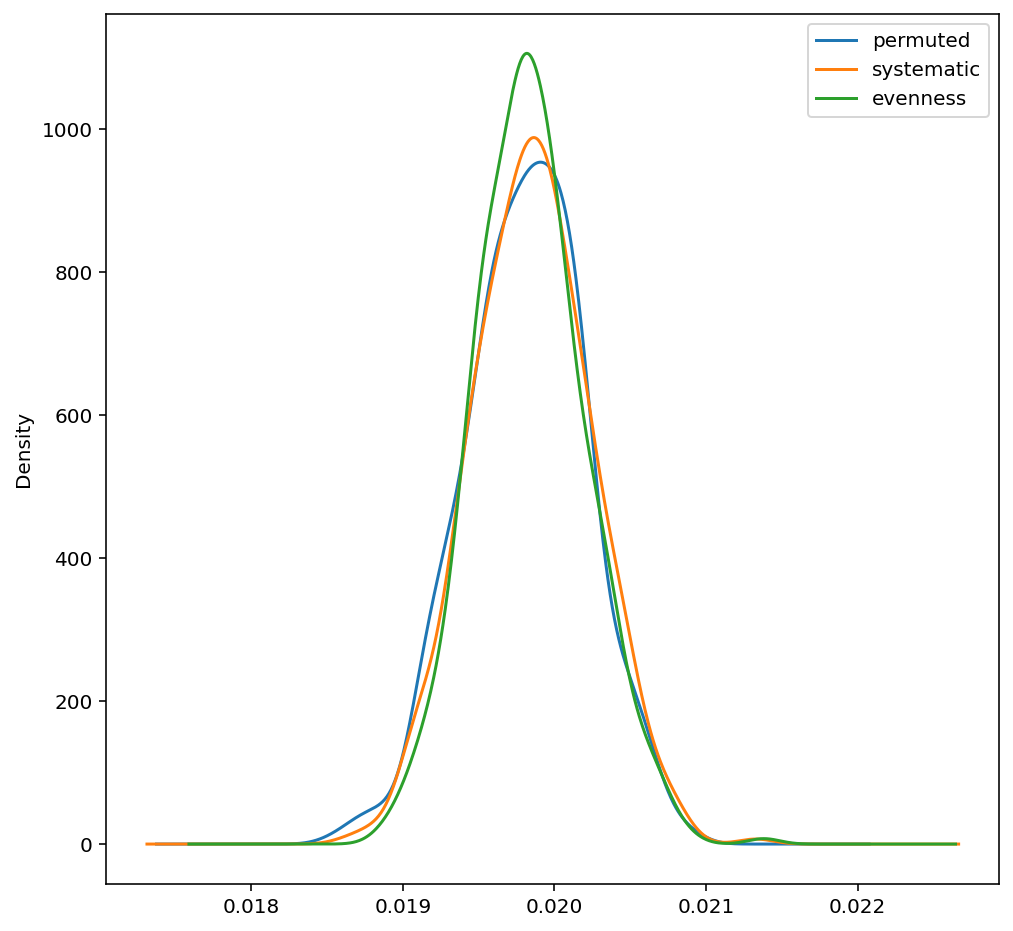

In [48]:
fig, ax = plt.subplots(figsize=(8,8))
G_permuted.name='permuted'
G_permuted.plot(kind='kde', ax=ax, legend=True)
G_systematic.name='systematic'
G_systematic.plot(kind='kde', ax=ax, legend=True)
G_even.name='evenness'
G_even.plot(kind='kde', ax=ax, legend=True)

### Multi Group

In [49]:
H_even = simulate_null(seg_class=H, sim_func=simulate_evenness)

In [50]:
H_systematic = simulate_null(seg_class=H, sim_func=simulate_systematic_randomization)

In [51]:
H_permuted = simulate_null(seg_class=H, sim_func=simulate_person_permutation)

/Users/knaaptime/anaconda3/envs/segregation/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


<AxesSubplot:ylabel='Density'>

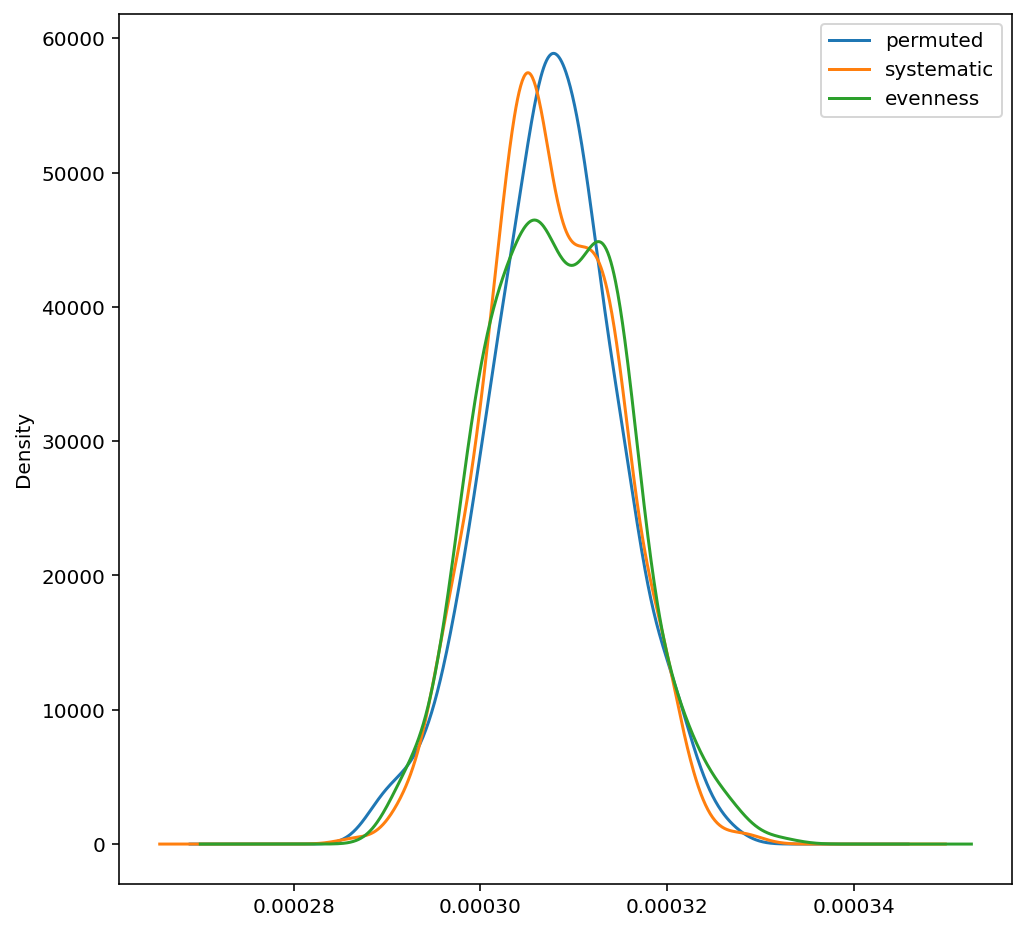

In [52]:
fig, ax = plt.subplots(figsize=(8,8))
H_permuted.name='permuted'
H_permuted.plot(kind='kde', ax=ax, legend=True)
H_systematic.name='systematic'
H_systematic.plot(kind='kde', ax=ax, legend=True)
H_even.name='evenness'
H_even.plot(kind='kde', ax=ax, legend=True)

Despite their different methods, all three approaches simulate similar distributions, but they differ with respect to *how* and in which dimensions the randomization occurs. As with [Boisso et al](http://dx.doi.org/10.1016/0304-4076(94)90082-5), the distribution is not centered on 0. In other cases, such as when minority populations are small or highly unbalanced among multiple groups, its possible that the different randomization methods could diverge to simulate different distributions